# Análise de Hard Failures com LSTNet


## 1. Carregamento e Configuração Inicial

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GRU, Dense, Lambda, Add
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix

In [19]:
try:
    df = pd.read_csv(r'D:/Projetos/UFABC/UFABC_Tambra/Dados/HardFailure_dataset.csv')
    # CORREÇÃO BUG 2: Tratar valores NaN na coluna 'Failure' antes de qualquer uso
    df['Failure'] = df['Failure'].fillna(0).astype(int)
    print("Dataset de Hard Failure carregado com sucesso!")
    print(df.head())
except FileNotFoundError as e:
    print(e)

Dataset de Hard Failure carregado com sucesso!
    Timestamp            Type          ID           BER  OSNR  InputPower  \
0  1623394635  Infrastructure      Ampli1           NaN   NaN       -23.0   
1  1623394634         Devices  SPO1/18/11  2.280000e-08  38.5         NaN   
2  1623394635         Devices  SPO2/18/11  8.730000e-07  23.5         NaN   
3  1623394635  Infrastructure      Ampli2           NaN   NaN       -15.5   
4  1623394635  Infrastructure      Ampli4           NaN   NaN       -22.9   

   OutputPower  Failure  
0          0.7        0  
1          NaN        0  
2          NaN        0  
3          0.4        0  
4          0.7        0  


## 2. Pré-processamento dos Dados

In [20]:
features = df.drop(columns=['Timestamp', 'Type', 'ID', 'Failure'])

train_size = int(len(features) * 0.7)
val_size = int(len(features) * 0.1)
train_df = features[:train_size]
val_df = features[train_size:train_size + val_size]
test_df = features[train_size + val_size:]

scaler = MinMaxScaler()
scaler.fit(train_df)
train_scaled = scaler.transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:(i + timesteps)])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

TIMESTEPS = 5
X_train, y_train = create_sequences(train_scaled, TIMESTEPS)
X_val, y_val = create_sequences(val_scaled, TIMESTEPS)
X_test, y_test = create_sequences(test_scaled, TIMESTEPS)

In [21]:
print("Shapes dos dados de treino (X, y):", X_train.shape, y_train.shape)
print("Shapes dos dados de validação (X, y):", X_val.shape, y_val.shape)
print("Shapes dos dados de teste (X, y):", X_test.shape, y_test.shape)

Shapes dos dados de treino (X, y): (46008, 5, 4) (46008, 4)
Shapes dos dados de validação (X, y): (6568, 5, 4) (6568, 4)
Shapes dos dados de teste (X, y): (13142, 5, 4) (13142, 4)


## 3. Construção do Modelo LSTNet

In [22]:
# CORREÇÃO BUG 1: A função foi corrigida para garantir que as saídas da GRU e da camada AR tenham shapes compatíveis antes da soma.
def build_lstnet_model(timesteps, n_features, conv_filters=10, kernel_size=3, gru_units=100):
    inputs = Input(shape=(timesteps, n_features))
    conv_out = Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu')(inputs)
    gru_out = GRU(gru_units, activation='relu')(conv_out)
    gru_proj = Dense(n_features)(gru_out)
    ar_input = Lambda(lambda x: x[:, -1, :])(inputs)
    ar_out = Dense(n_features)(ar_input)
    combined = Add()([gru_proj, ar_out])
    outputs = combined
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [23]:
n_features = X_train.shape[2]
lstnet_model = build_lstnet_model(TIMESTEPS, n_features)
lstnet_model.compile(optimizer='adam', loss='mean_squared_error')
lstnet_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 5, 4)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 3, 10)     │        130 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 100)       │     33,600 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 4)         │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 4)         │        404 │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 4)         │         20 │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 4)         │          0 │ dense_4[0][0],    │
│                     │                   │            │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,154 (133.41 KB)

 Trainable params: 34,154 (133.41 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Treinamento do Modelo

In [24]:
print("Iniciando o treinamento do modelo LSTNet para Hard Failures...")
history = lstnet_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)


Iniciando o treinamento do modelo LSTNet para Hard Failures...
Epoch 1/50
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: nan - val_loss: nan
Epoch 2/50
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan - val_loss: nan
Epoch 3/50
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan - val_loss: nan
Epoch 4/50
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan - val_loss: nan
Epoch 5/50
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan - val_loss: nan
Epoch 6/50
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan - val_loss: nan
Epoch 7/50
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan - val_loss: nan
Epoch 8/50
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan - val_loss: nan
Epoch 9/50
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan - val_loss: nan
Epoch 10/50
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: nan - val_loss: nan
Epoch 11/50
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan - val_loss: nan
Epoch 12/50
1438/1438 ━━━━━━━━━━━

## 5. Avaliação do Treinamento e Definição do Limiar de Anomalia

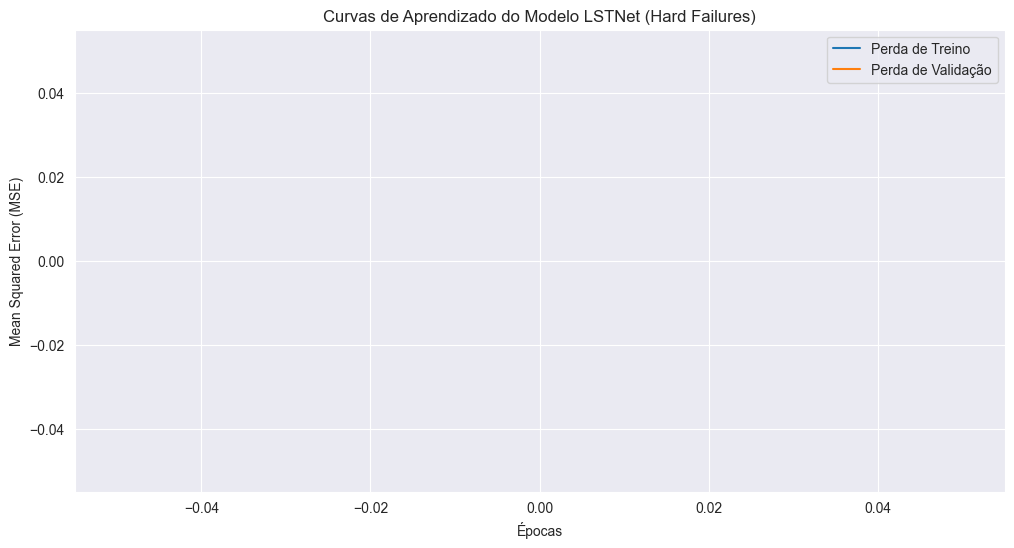

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Perda de Treino')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Curvas de Aprendizado do Modelo LSTNet (Hard Failures)')
plt.xlabel('Épocas')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

1438/1438 ━━━━━━━━━━━━━━━━━━━━ 1s 649us/step

Limiar de Anomalia (Threshold) calculado: nan


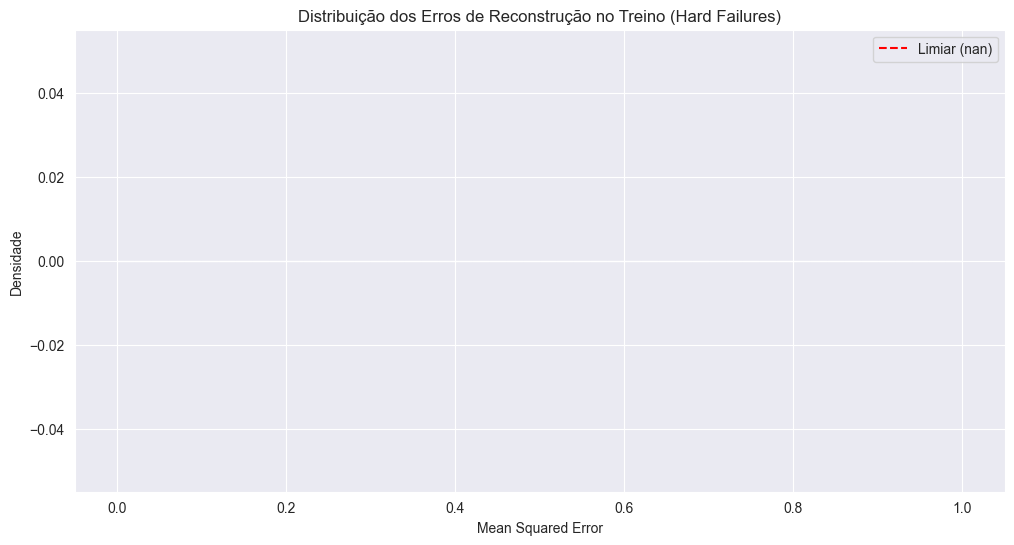

In [26]:
train_predictions = lstnet_model.predict(X_train)
train_mse = np.mean(np.square(train_predictions - y_train), axis=1)
threshold = np.quantile(train_mse, 0.99)

print(f"\nLimiar de Anomalia (Threshold) calculado: {threshold:.5f}")

plt.figure(figsize=(12, 6))
sns.histplot(train_mse, bins=50, kde=True)
plt.axvline(threshold, color='r', linestyle='--', label=f'Limiar ({threshold:.5f})')
plt.title('Distribuição dos Erros de Reconstrução no Treino (Hard Failures)')
plt.xlabel('Mean Squared Error')
plt.ylabel('Densidade')
plt.legend()
plt.show()

## 6. Detecção de Falhas e Avaliação Final

In [27]:
test_predictions = lstnet_model.predict(X_test)
test_mse = np.mean(np.square(test_predictions - y_test), axis=1)
anomalies = test_mse > threshold

print(f"Total de amostras no teste: {len(X_test)}")
print(f"Número de anomalias detectadas: {np.sum(anomalies)}")

411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step
Total de amostras no teste: 13142
Número de anomalias detectadas: 0


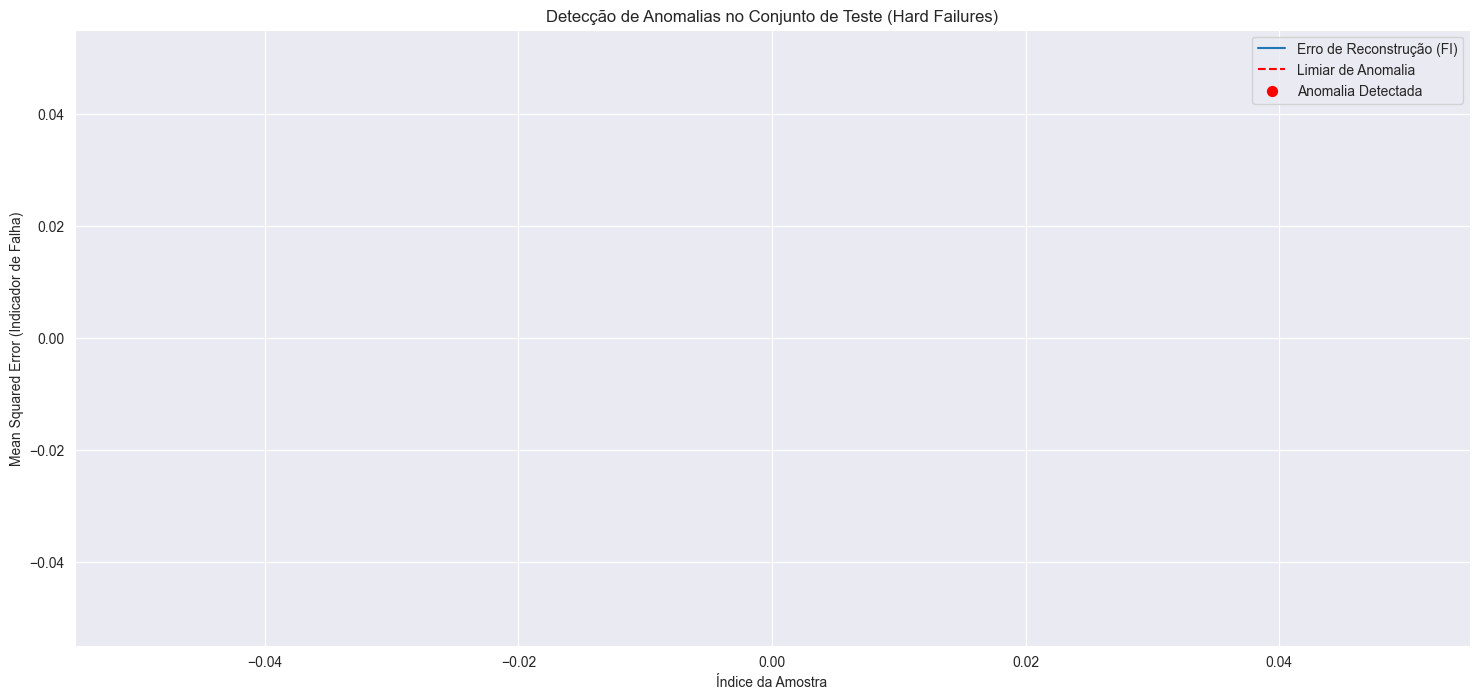

In [28]:
anomaly_df = pd.DataFrame(test_df[TIMESTEPS:])
anomaly_df['error'] = test_mse
anomaly_df['anomaly'] = anomalies

plt.figure(figsize=(18, 8))
plt.plot(anomaly_df.index, anomaly_df.error, label='Erro de Reconstrução (FI)')
plt.axhline(threshold, color='r', linestyle='--', label='Limiar de Anomalia')
anomaly_points = anomaly_df[anomaly_df['anomaly']]
plt.scatter(anomaly_points.index, anomaly_points.error, color='red', label='Anomalia Detectada', s=50)

plt.title('Detecção de Anomalias no Conjunto de Teste (Hard Failures)')
plt.xlabel('Índice da Amostra')
plt.ylabel('Mean Squared Error (Indicador de Falha)')
plt.legend()
plt.grid(True)
plt.show()

actual_failures = df['Failure'][train_size + val_size + TIMESTEPS:].values


--- Performance da Detecção de Hard Failures ---
              precision    recall  f1-score   support

           0       0.81      1.00      0.90     10657
           1       0.00      0.00      0.00      2485

    accuracy                           0.81     13142
   macro avg       0.41      0.50      0.45     13142
weighted avg       0.66      0.81      0.73     13142



D:\Projetos\UFABC\UFABC_Tambra\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\Projetos\UFABC\UFABC_Tambra\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\Projetos\UFABC\UFABC_Tambra\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

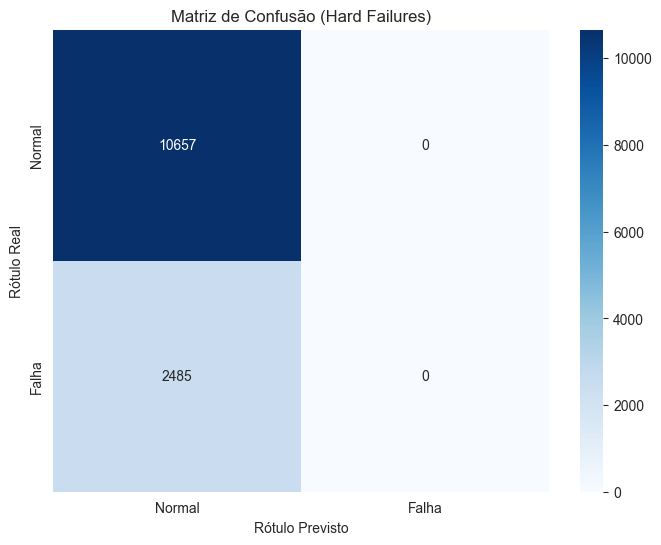

In [29]:
print("\n--- Performance da Detecção de Hard Failures ---")
print(classification_report(actual_failures, anomalies))

cm = confusion_matrix(actual_failures, anomalies)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Falha'], yticklabels=['Normal', 'Falha'])
plt.title('Matriz de Confusão (Hard Failures)')
plt.ylabel('Rótulo Real')
plt.xlabel('Rótulo Previsto')
plt.show()